In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split 
from torch.nn import functional as F  
import torch.optim as optim
from torchsummary import summary 

 
import numpy as np
import matplotlib
import matplotlib.pyplot as mplot
from matplotlib.colors import ListedColormap
import os
import subprocess
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score,  precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
 
 # Convert to PyTorch tensors
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary 


import random
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import pydotplus
import seaborn as sns

from tabulate import tabulate 


In [ ]:
dataSetIndex = 4
needToMakePictureOfTrees = 0
''' ---------------------------------------------------------- '''
dataSetFilePath = ""
dataSetName = ""
dataSetResultDirectory = "./"

if(dataSetIndex == 0):
    dataSetFilePath = "./heartDisease/0_statLog_dataSet.csv"
    dataSetName = "SateLog_DataSet"
elif (dataSetIndex == 1):
    dataSetFilePath = "./heartDisease/1_heart_statlog_cleveland_hungary_final.csv"
    dataSetName = "ALL_StateLog_CleveLand_Hungary"
elif (dataSetIndex == 2):
    dataSetFilePath = "./heartDisease/2_cleveland.csv"
    dataSetName = "Cleveland"
elif (dataSetIndex == 3):
    dataSetFilePath = "./heartDisease/3_framingham.csv"
    dataSetName = "framingham"
elif (dataSetIndex == 4):
    dataSetFilePath = "./heartDisease/4_CardiacPrediction.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 5):
    dataSetFilePath = "./heartDisease/5_CardiacPredictionLessDimensions.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 6):
    dataSetFilePath = "./heartDisease/6_CardiacPredictionFewDimensions.xlsx"
    dataSetName = "CardiacPrediction"
else:
    dataSetFilePath = ""
    dataSetName = ""

if(dataSetIndex==4 or dataSetIndex==5 or dataSetIndex==6):
    #fileData = pd.read_excel(dataSetFilePath, sheet_name='CoroHeartDis')
    fileData = pd.read_excel(dataSetFilePath)
else:
    fileData = pd.read_csv(dataSetFilePath)

print("Shape of fileData: {}".format(fileData.shape))
print("Column Headings: {}".format(fileData.__dataframe__().column_names()))
print("Number of Records: {}".format(fileData.__dataframe__().num_rows()))


missingValues = fileData.isnull().any().sum()
print(f"\nNumber of Missing Values: {missingValues}")

num_rows_before = fileData.shape[0] 
fileData.drop_duplicates(inplace=True) 
num_rows_after = fileData.shape[0] 
num_duplicates_removed = num_rows_before - num_rows_after
print(f"Number of duplicate records removed: {num_duplicates_removed}")
fileData = fileData.dropna()
print("Shape of fileData: {}".format(fileData.shape))   
fileData = fileData.fillna(0) 

print("Shape of fileData End: {}".format(fileData.shape))



finalResultTable = [ ['Index', 'Method', 'Accuracy %','Recall %','Precision %','F1 Score','AUC'], ]  

X = fileData.drop(fileData.__dataframe__().column_names()[-1], axis=1)  # Features
Y = fileData[fileData.__dataframe__().column_names()[-1]]  # Labels

columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())

print("\n")
print("columns of x:: {} \n\n and features of X: {}".format(len(X.columns), X.columns))

dataSetResultDirectory = "./"
dataSetResultDirectory += ("DatasetResults_PyTorch_" + dataSetName)
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)

dataSetName += " {}".format(fileData.shape)



In [ ]:
print("Shape of fileData: {} , target Len:{}".format(fileData.shape, len(Y)))
print("X: {} , Y:{}".format(X.shape, Y.shape))
#print("\n\nX: head:: \n{}".format(X.head()))
#print("\n\nY: head::\n {}".format(Y.head()))

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
 

print("Target Column Name:: {} \n".format(fileData.__dataframe__().column_names()[-1]))


rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

'''
# Undersample the majority class
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
'''

# Oversample the minority class using SMOTE
X_train, y_train = smote.fit_resample(X_train, y_train)
#X_test, y_test = rus.fit_resample(X_test, y_test)
X_test, y_test = smote.fit_resample(X_test, y_test) 


scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#Y_train_scaled = scaler.transform(y_train)
#Y_test_scaled = scaler.transform(y_test)

 


print("\n X Train: Shape:: {}".format(X_train.shape))
print(" X Test: Shape:: {}".format(X_test.shape))  
 
 
positiveClass =  0
negativeClass = 0
for i in y_train:
    if(i == 0):
        negativeClass += 1
    if(i == 1):
        positiveClass += 1
print("Train DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Train DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Train DataSet Total Records:: {}".format(positiveClass + negativeClass)) 

print("\n\n") 


positiveClass =  0
negativeClass = 0
for i in y_test:
    if(i == 0):
        negativeClass += 1
    if(i == 1):
        positiveClass += 1
print("Test DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Test DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Test DataSet Total Records:: {}".format(positiveClass + negativeClass)) 



In [ ]:
def makeCorrelationPic(correlationMatrix, numberOfTopFeatures, targetColumnName):     
    correlation_values = correlationMatrix.abs()
    sorted_correlation = correlation_values.unstack().sort_values(ascending=False)
    sorted_correlation = sorted_correlation[sorted_correlation != 1.0]

    num_features = numberOfTopFeatures  # Number of top features to display
    top_features = sorted_correlation.head(num_features)
    print("Top", num_features, "features based on correlation:")
    print(top_features)
 
    top_features = correlationMatrix.abs().nlargest(numberOfTopFeatures, targetColumnName)[targetColumnName].index
    top_correlation_matrix = correlationMatrix.loc[top_features, top_features]

    mplot.figure(figsize=(10, 8))
    sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm')
    # Set the title of the plot
    mplot.title('Correlation Heatmap ({})'.format(dataSetName))
    
    picturePath = "Correlation_Matrix_DateSetName_{}.png".format(dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    mplot.show()
    mplot.close()

def makeConfusionMatrixPic(method, dataSet, classifierObj , X_test, y_test, predicted_Y):
    display = ConfusionMatrixDisplay.from_estimator(classifierObj, X_test, y_test, display_labels=['Healthy', "Heart Disease"], cmap=mplot.cm.Blues) #, normalize="true"
    display.ax_.set_title("Confusion Matrix ({} Model)".format(method))
    display.ax_.set_xlabel('\nPredicted Values')
    display.ax_.set_ylabel('Actual Values ')


    accuracyString ="Accuracy {}: {:.2f}".format(method, accuracy_score(y_test, predicted_Y)*100.0 ) 
    recallString =  'Recall {}: {:.2f}'.format(method, recall_score(y_test, predicted_Y) * 100.0)
    precisionString = 'Precision {}: {:.2f}'.format(method, precision_score(y_test, predicted_Y) * 100.0) 
    dataSetString = "Dataset: {}".format(dataSet)

    
    if(classifierObj.n_features_in_ > 10):
        featureListString = 'Total Features: {}'.format(classifierObj.n_features_in_) 
    else:
        featureListString = 'Features: {}'.format(classifierObj.feature_names_in_) 
    
    display.figure_.text(0.010, -0.05,  accuracyString, horizontalalignment='left', wrap=False )  
    display.figure_.text(0.010, -0.09,  recallString, horizontalalignment='left', wrap=False )      
    display.figure_.text(0.010, -0.13,  precisionString, horizontalalignment='left', wrap=False ) 
    display.figure_.text(0.010, -0.17,  dataSetString, horizontalalignment='left', wrap=False ) 
    display.figure_.text(0.010, -0.28,  featureListString, horizontalalignment='left', wrap=False ) 
 
    picturePath = "{}Confusion_Matrix_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #print("{} Confusion Matrix saved:: path: {}".format(method, picturePath))
    #os.startfile(picturePath)
    mplot.show()
    mplot.close()


In [ ]:
# Convert to PyTorch tensors
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
import pandas as pd

'''
# Convert the data to PyTorch tensors
X_train_np = X_train.to_numpy()  # Convert DataFrame to NumPy array
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).cuda()
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test) 
X_train_f32 = np.asarray(X_train).astype(np.float32)  #.astype('float32').reshape((-1,1))
X_test_f32 = np.asarray(X_test).astype(np.float32)
#y_train_scaler = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test_scaler = np.asarray(y_test).astype('float32').reshape((-1,1))
features = X_train_scaler # data.iloc[:, :-1]
target = np.asarray(y_train).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease'] 
y_train_tensor = torch.tensor(target, dtype=torch.float32).view(-1, 1).cuda()

'''

X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32).cuda()
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).cuda()
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32).cuda()
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).cuda()
#print(X_train_tensor)
#print(y_train_tensor) 
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)
print(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(train_loader)


In [42]:
 
features = X_train_tensor 
target = y_train_tensor
 
  
print("X_train shape: {}   and dType: {}".format(X_train.shape, len(X_train.columns)))
print("y_train shape: {}   and dType: {}".format(y_train.shape, y_train.dtype))  

print("X_train_tensor shape: {}   and dType: {}".format(X_train_tensor.shape, X_train_tensor.dtype))
print("y_train_tensor shape: {}   and dType: {}".format(y_train_tensor.shape, y_train_tensor.dtype)) 


print("X_test_tensor shape: {}   and dType: {}".format(X_test_tensor.shape, X_test_tensor.dtype))
print("y_test_tensor shape: {}   and dType: {}".format(y_test_tensor.shape, y_test_tensor.dtype)) 



print("features shape: {}   and dType: {}".format(features.shape, features.dtype))
print("target shape: {}   and dType: {}".format(target.shape, target.dtype)) 

X_train shape: (49798, 50)   and dType: 50
y_train shape: (49798,)   and dType: int64
X_train_tensor shape: torch.Size([49798, 50])   and dType: torch.float32
y_train_tensor shape: torch.Size([49798])   and dType: torch.float32
X_test_tensor shape: torch.Size([21344, 50])   and dType: torch.float32
y_test_tensor shape: torch.Size([21344])   and dType: torch.float32
features shape: torch.Size([49798, 50])   and dType: torch.float32
target shape: torch.Size([49798])   and dType: torch.float32


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
import pandas as pd
 

# Define the attention layer
class AttentionLayer(nn.Module):
    def __init__(self, input_size):
        super(AttentionLayer, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=input_size // 2, num_heads=1)
    def forward(self, q, v):
        attention_weights, _ = self.attention(q.unsqueeze(0), v.unsqueeze(0), v.unsqueeze(0))
        return attention_weights.squeeze(0)
    

# Define the model
class CustomModel(nn.Module):
    def __init__(self, input_size): 
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(input_size)
        self.fc2 = nn.Linear(input_size, input_size // 2)
        self.attention = AttentionLayer(input_size)
        self.fc3 = nn.Linear(input_size, input_size // 2)  # Adjusted input_size here
        self.batch_norm2 = nn.BatchNorm1d(input_size // 2)
        self.output_layer = nn.Linear(input_size // 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Traditional neural network part 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.fc2(x)
        # Attention layer
        attention = self.attention(x, x)
        # Combine the output of the attention layer with the previous layer
        x = torch.cat([x, attention], dim=1)
        # Another dense layer
        x = self.fc3(x)
        x = self.batch_norm2(x)
        # Output layer
        x = self.output_layer(x)
        x = self.sigmoid(x)

        return x

# Instantiate the model
input_size = X_train_tensor.shape[1]  # Assuming 'features' is a torch tensor
print(input_size)
model = CustomModel(input_size).cuda()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
 
# Training the model
numberOfEpochs = 20
batchSizeOfTraining = 25 

for epoch in range(numberOfEpochs):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    
    # Assuming y_train_tensor is of shape [49798, 1]
    # If not, make sure to reshape it to have the same shape as the output
    loss = criterion(output, y_train_tensor.view(-1, 1))  # Ensure y_train_tensor has shape [49798, 1]
    
    loss.backward()
    optimizer.step()

50


In [38]:
with torch.no_grad():
    model.eval()
    y_pred = model(X_test_tensor)
    loss = criterion(y_pred, y_test_tensor.view(-1, 1))
    accuracy = ((y_pred > 0.5) == y_test_tensor.byte()).float().mean().item()

# Print the results
print('Test loss: {}'.format(loss.item()))
print('Test accuracy: {}'.format(accuracy))

Test loss: 0.6756048202514648
Test accuracy: 0.4999999701976776


In [41]:
print(len(y_pred))
print(len(y_pred))


21344


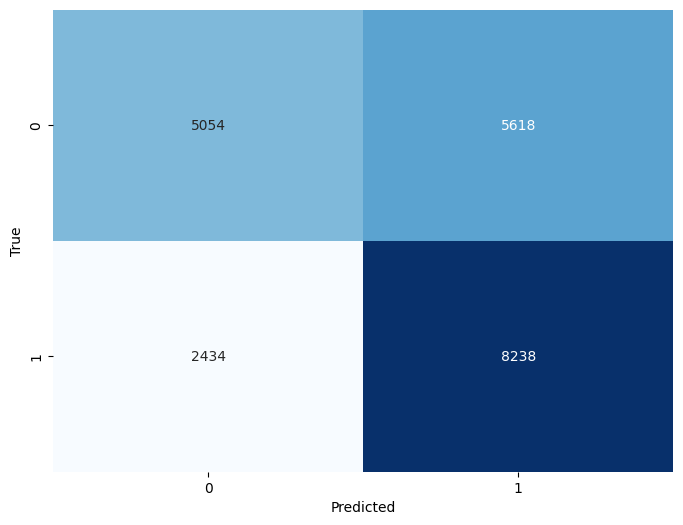

              precision    recall  f1-score   support

         0.0       0.67      0.47      0.56     10672
         1.0       0.59      0.77      0.67     10672

    accuracy                           0.62     21344
   macro avg       0.63      0.62      0.61     21344
weighted avg       0.63      0.62      0.61     21344



In [44]:
from sklearn.metrics import confusion_matrix, classification_report
 
y_test_cpu = y_test_tensor.cpu().numpy()

# Convert to binary predictions (assuming binary classification)
binary_predictions = [1 if pred > 0.5 else 0 for pred in y_pred]

# Draw confusion matrix
cm = confusion_matrix(y_test_cpu, binary_predictions)
mplot.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
mplot.xlabel("Predicted")
mplot.ylabel("True")
picturePath = "{}Confusion_Matrix_{}_{}.png".format(dataSetResultDirectory, "MLP+Attention", dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
mplot.show()
mplot.close()

# Print classification report
print(classification_report(y_test_cpu, binary_predictions))


In [34]:

# Convert to binary predictions (assuming binary classification)
binary_predictions = [1 if pred > 0.5 else 0 for pred in y_pred]
true_labels = y_test_tensor.cuda()  # ["Healthy", "Heart Patient"]
# Draw confusion matrix
cm = confusion_matrix(y_test_tensor, y_pred)
mplot.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
mplot.xlabel("Predicted")
mplot.ylabel("True")
mplot.show()
mplot.close()

# Print classification report
print(classification_report(y_test_tensor, y_pred))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
  



  

In [ ]:

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert to binary predictions (assuming binary classification)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Draw confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)
mplot.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
mplot.xlabel("Predicted")
mplot.ylabel("True")
mplot.show()

# Print classification report
print(classification_report(true_labels, binary_predictions))